# 랜덤 포레스트 기반 눈 감음 분류 (500장 샘플링)
- 각 클래스(open/closed)에서 500장씩 샘플링하여 학습
- 데이터 경로: `./open-closed-eyes-dataset/train`

In [7]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
data_dir = './open-closed-eyes-dataset/train'
closed_path = os.path.join(data_dir, 'closed')
open_path = os.path.join(data_dir, 'open')

# 500장씩 샘플링
closed_files = random.sample(os.listdir(closed_path), 500)
open_files = random.sample(os.listdir(open_path), 500)

df = pd.DataFrame({
    "filename": [os.path.join("closed", f) for f in closed_files] + [os.path.join("open", f) for f in open_files],
    "class": ["closed"] * 500 + ["open"] * 500
})

df = df.sample(frac=1, random_state=42).reset_index(drop=True)


## 데이터 제너레이터 생성 (500장씩, 검증 20%)

In [8]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_dir,
    x_col="filename",
    y_col="class",
    target_size=(64, 64),
    class_mode='binary',
    subset="training",
    batch_size=64,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_dir,
    x_col="filename",
    y_col="class",
    target_size=(64, 64),
    class_mode='binary',
    subset="validation",
    batch_size=64,
    shuffle=False
)

Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


## 제너레이터에서 전체 데이터 수집 (Flatten)

In [9]:
def extract_all_data(generator):
    X, y = [], []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        X.append(x_batch)
        y.append(y_batch)
    return np.vstack(X), np.hstack(y)

X_train, y_train = extract_all_data(train_gen)
X_val, y_val = extract_all_data(val_gen)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

## 표준화 및 랜덤포레스트 학습

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

## 예측 및 성능 평가

In [12]:
y_pred = model.predict(X_val_scaled)

print("정확도:", accuracy_score(y_val, y_pred))
print("\n분류 리포트:\n", classification_report(y_val, y_pred))
print("\n혼동행렬:\n", confusion_matrix(y_val, y_pred))

정확도: 0.935

분류 리포트:
               precision    recall  f1-score   support

         0.0       0.95      0.92      0.93        96
         1.0       0.93      0.95      0.94       104

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200


혼동행렬:
 [[88  8]
 [ 5 99]]


<Figure size 600x600 with 0 Axes>

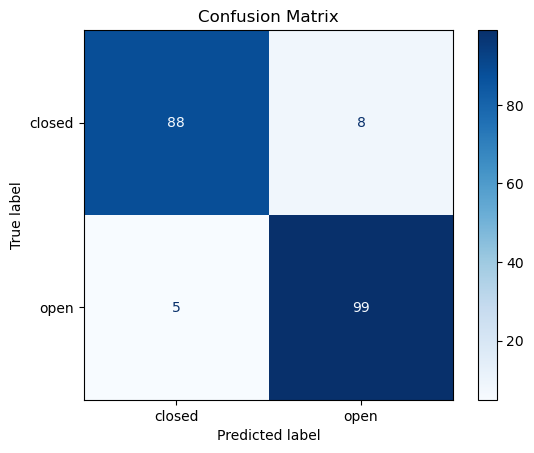

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 혼동행렬 시각화
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['closed', 'open'])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


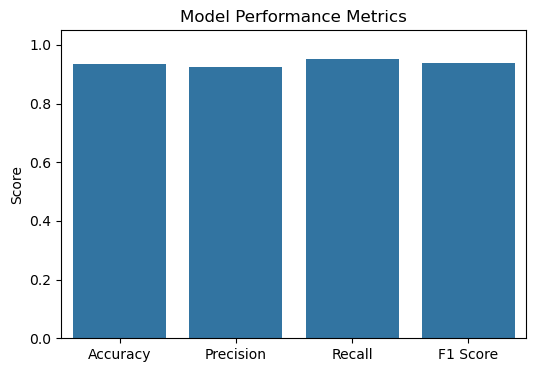

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

plt.figure(figsize=(6, 4))
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
sns.barplot(x=labels, y=metrics)
plt.ylim(0.0, 1.05)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()
